In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
from bayesopt.bayesian_optimizer import BayesianOptimizer
from bayesopt import acquisitions
from bayesopt import model
from bayesopt import utils as ut
from bayesopt import metrics as boptmets

In [3]:
def run_bo_campaign(oracle, internal_model, acq, init_data, testable_points, y_true, n_its = 200, acq_kwargs = {'xi':0.25}, method = 'max', thresh = 0.7):
    # 1. run bayesian optimizer
    bopt = BayesianOptimizer(oracle, acq, internal_model, init_data, method = method, valid_points = testable_points, acq_kwargs = acq_kwargs)
    results = bopt.optimization_campaign(n_iterations = n_its)
    #2. process bopt results: get metrics
    bo_loss = [entry['oracleresult'][0] for entry in list(results.values())]
    queried_points = [entry['querypts'][0] for entry in list(results.values())]
    queried_points = np.stack(queried_points)
    #3. run a random campaign
    rng = np.random.default_rng()
    randinds = rng.integers(0, len(testable_points), n_its)
    random_points = testable_points[randinds]
    y_random = oracle.predict(random_points)
    
    #4. process random results
    
    # metrics
    bo_tp = boptmets.top_percent_campaign(testable_points, y_true, queried_points, threshold = thresh)
    rand_tp = boptmets.top_percent_campaign(testable_points, y_true, random_points, threshold= thresh)
    ef = boptmets.enhancement_factor(testable_points, y_true, queried_points, random_points, toppercent_threshold= thresh)
    acc_fact = boptmets.acceleration_factor(testable_points, y_true, queried_points, random_points, toppercent_threshold=thresh)
    
    return {'bo_points':queried_points, 'bo_loss':bo_loss, 'rand_points':random_points, 'bo_toppercent':bo_tp, 'rand_toppercent':rand_tp, 'enhancement_factor':ef, 'acceleration_factor':acc_fact, 'optimizer':bopt}

In [4]:
def metrics_plot(results):
    fig, ax = plt.subplots(1,3, figsize = (12, 4))

    ax[0].plot(results['bo_toppercent'], label = 'BO')
    ax[0].plot(results['rand_toppercent'], label = 'Random')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('fraction found')
    ax[0].set_title('Top Percent')
    ax[0].legend()

    ax[1].plot(results['enhancement_factor'])
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Enhancement Factor')
    ax[1].set_title('Enhancement Factor')

    ax[2].plot(results['acceleration_factor'][0], results['acceleration_factor'][1])
    ax[2].set_xlabel('TopPercent Threshold')
    ax[2].set_ylabel('Acceleration Factor')
    ax[2].set_title('Acceleration Factor')

    plt.tight_layout()
    
    return fig

In [60]:
def contour_plots(design_space_points, oracle_values, results_points, best_point):
    agn03 = 0
    pva = 1
    tsc = 2
    seed = 3
    flow = 4

    fig, ax = plt.subplots(1,3, figsize = (13,4), gridspec_kw={'width_ratios': [1, 1, 1.2]})

    #ax[0].set_xlim(0.05, 0.9)
    #ax[0].set_ylim(0.05, 0.9)
    ax[0].tricontourf(design_space_points[:,agn03], design_space_points[:,seed], z_plot)
    #ax[0].scatter(results_points[:,agn03], results_points[:, seed], color = 'k')
    
    for i, (xplot, yplot) in enumerate(zip(results_points[:,agn03], results_points[:,seed])):
        ax[0].scatter(xplot, yplot, color = ut.lighten_color('gray', 1- i/len(results_points)))
        
    ax[0].scatter(best_point[agn03], best_point[seed], color = 'r', marker = '*')
    ax[0].set_xlabel('$Q_{AgNO_3}$')
    ax[0].set_ylabel('$Q_{seed}$')


    #ax[1].set_xlim(0.1, 0.4)
    #ax[1].set_ylim(0.05, 0.9)
    ax[1].tricontourf(design_space_points[:,pva], design_space_points[:,tsc], z_plot)
    #ax[1].scatter(results_points[:,pva], results_points[:, tsc], color = 'k')
    
    for i, (xplot, yplot) in enumerate(zip(results_points[:,pva], results_points[:,tsc])):
        ax[1].scatter(xplot, yplot, color = ut.lighten_color('gray', 1- i/len(results_points)))
        
    ax[1].scatter(best_point[pva], best_point[tsc], color = 'r', marker = '*')
    ax[1].set_xlabel('$Q_{PVA}$')
    ax[1].set_ylabel('$Q_{tsc}$')


    #ax[2].set_xlim(0.1, 0.4)
    #ax[2].set_ylim(200, 1000)
    ax[2].tricontourf(design_space_points[:,agn03], design_space_points[:,flow], z_plot)
    #ax2 = ax[2].scatter(results_points[:,agn03], results_points[:, flow], color = 'k')
    
    for i, (xplot, yplot) in enumerate(zip(results_points[:,agn03], results_points[:,flow])):
        ax[2].scatter(xplot, yplot, color = ut.lighten_color('gray', 1- i/len(results_points)))
        
    ax2 = ax[2].scatter(best_point[agn03], best_point[flow], color = 'r', marker = '*')
    ax[2].set_xlabel('$Q_{AgNO_3}$')
    ax[2].set_ylabel('Flowrate')
    plt.colorbar(ax2, ax = ax[2], label = 'Inverse Loss')

    plt.tight_layout()
    
    return fig

In [77]:
font = {'size':14}
matplotlib.rc('font', **font)

## 1. Load data from source

In [6]:
agnp_data = pd.read_csv('https://raw.githubusercontent.com/kiranvad/DOE/master/final_project_data/AgNP_dataset.csv')

In [7]:
agnp_data

,QAgNO3(%),Qpva(%),Qtsc(%),Qseed(%),Qtot(uL/min),loss
0,13.101322,32.995595,5.603524,4.528634,227.0,0.579592
1,13.101322,32.995595,5.603524,4.528634,227.0,0.581558
2,13.101322,32.995595,5.603524,4.528634,227.0,0.582454
3,13.101322,32.995595,5.603524,4.528634,227.0,0.582043
4,13.101322,32.995595,5.603524,4.528634,227.0,0.592302
...,...,...,...,...,...,...
3290,36.501053,14.000000,10.501053,4.501053,950.0,0.264635
3291,36.501053,14.000000,10.501053,4.501053,950.0,0.265406
3292,36.501053,14.000000,10.501053,4.501053,950.0,0.263623
3293,36.501053,14.000000,10.501053,4.501053,950.0,0.252167


## 2. Build an oracle model

In [8]:
X = agnp_data[['QAgNO3(%)', 'Qpva(%)', 'Qtsc(%)', 'Qseed(%)', 'Qtot(uL/min)']].to_numpy()
y = agnp_data['loss'].to_numpy()


In [9]:

scale = preprocessing.MinMaxScaler()
oraclemodel = RandomForestRegressor(n_estimators = 500)


y_scaled = preprocessing.MinMaxScaler().fit_transform(y.reshape(-1,1))
y_inv = 1 - y_scaled

X_train, X_test, y_train, y_test = train_test_split(X, y_inv, random_state = 42)


#oracle = GaussianProcessRegressor(kernel = 1.0*kernels.Matern())
estimator = Pipeline([('estimator', oraclemodel)])
estimator.fit(X_train, y_train)


/Users/bgpelkie/miniconda3/envs/doe/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('estimator', RandomForestRegressor(n_estimators=500))])

In [10]:
oracle = ut.Oracle(estimator, 0.025)

In [46]:
y_pred = estimator.predict(X_test)

In [12]:
mae = metestimators.mean_absolute_error(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)


print('MAE: ', mae)
print('mape: ', mape)
print('mse: ', mse)
print('r2: ', r2)

MAE:  0.04481644054221246
mape:  0.1710349626748888
mse:  0.004105852917180604
r2:  0.9404034064405372


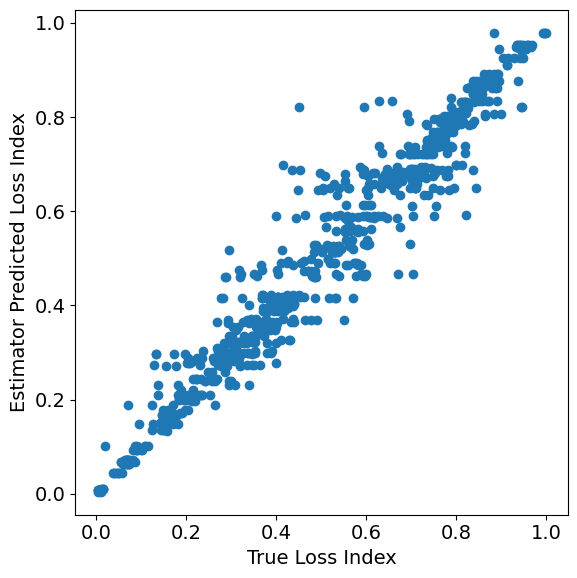

In [78]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(y_test, y_pred)
ax.set_xlabel('True Loss Index')
ax.set_ylabel('Estimator Predicted Loss Index')
plt.tight_layout()

plt.savefig('Nanoparticle_parity.png', dpi = 300)

In [14]:
X_test.min()

0.498851653

## 3. Sample initial points to seed BO

#### Define sample space of points we can sample from:

In [15]:
upper_bounds = np.ceil(X.max(axis = 0))
lower_bounds = np.floor(X.min(axis = 0))

In [16]:
upper_bounds

array([ 43.,  41.,  31.,  20., 983.])

In [17]:
lower_bounds

array([  4.,   9.,   0.,   0., 200.])

In [18]:
QAgNO3 = np.linspace(lower_bounds[0], upper_bounds[0], 15)
Qpva = np.linspace(lower_bounds[1], upper_bounds[1], 15)
Qtsc = np.linspace(lower_bounds[2], upper_bounds[2], 15)
Qseed = np.linspace(lower_bounds[3], upper_bounds[3], 15)


test_arr = np.array(np.meshgrid(QAgNO3, Qpva, Qtsc, Qseed)).T.reshape(-1,4)

indices = np.where(test_arr[:,0:4].sum(axis = 1) > 90)[0]

testable_points = np.delete(test_arr, indices, axis = 0)

In [19]:
Q_rate = np.linspace(200, 1000, 15)

In [20]:
np.max(testable_points, axis = 0)

array([43., 41., 31., 20.])

In [21]:
all_points = np.zeros((len(Q_rate)*len(testable_points), 5))

for i in range(len(Q_rate)):
    Q = Q_rate[i]*np.ones((len(testable_points), 1))

    ind = i*len(testable_points)

    all_points[ind:ind+len(testable_points),:4] = testable_points
    all_points[ind:ind+len(testable_points),4] = Q.reshape(-1)

In [22]:
np.max(all_points, axis = 0)

array([  43.,   41.,   31.,   20., 1000.])

In [23]:
rng = np.random.default_rng(seed = 4)

selected_inds = rng.integers(0, len(all_points), 15)

selected_points = all_points[selected_inds, :]

In [24]:
selected_inds

array([434863, 564532, 527621, 306090, 562965, 584399, 580832,  48390,
       271487, 363575, 169487, 225372, 375316, 480034, 347740])

In [25]:
y_init = oracle.predict(selected_points)

In [26]:
selected_points

array([[  34.64285714,   20.42857143,    0.        ,   18.57142857,
         771.42857143],
       [  40.21428571,   11.28571429,   26.57142857,    1.42857143,
        1000.        ],
       [  31.85714286,   13.57142857,   26.57142857,    2.85714286,
         942.85714286],
       [  29.07142857,   29.57142857,    6.64285714,   12.85714286,
         600.        ],
       [   9.57142857,   11.28571429,   11.07142857,    1.42857143,
        1000.        ],
       [  23.5       ,   25.        ,   26.57142857,   11.42857143,
        1000.        ],
       [   6.78571429,   31.85714286,   15.5       ,   10.        ,
        1000.        ],
       [  40.21428571,    9.        ,   22.14285714,    2.85714286,
         257.14285714],
       [  17.92857143,   11.28571429,   11.07142857,   15.71428571,
         542.85714286],
       [  37.42857143,   11.28571429,   11.07142857,    1.42857143,
         714.28571429],
       [   6.78571429,   20.42857143,    6.64285714,    4.28571429,
         428

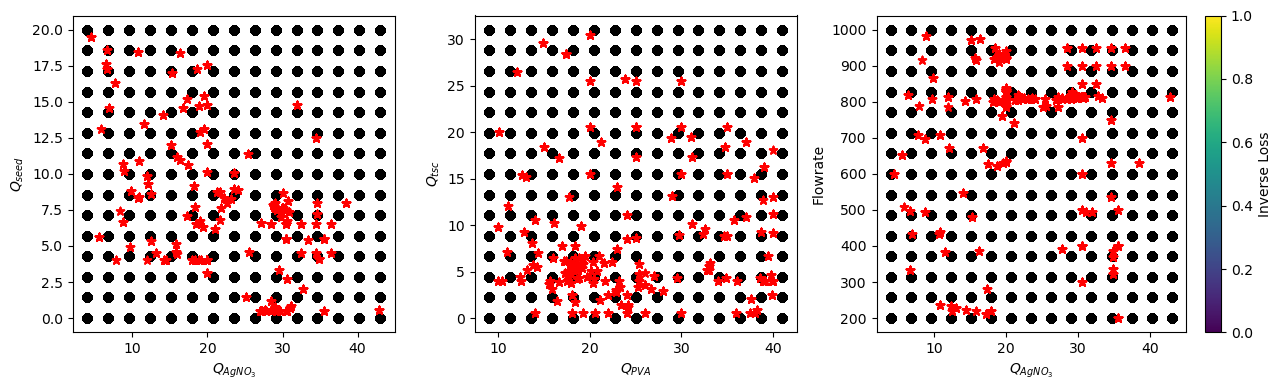

In [27]:
agn03 = 0
pva = 1
tsc = 2
seed = 3
flow = 4

fig, ax = plt.subplots(1,3, figsize = (13,4), gridspec_kw={'width_ratios': [1, 1, 1.2]})

#ax[0].set_xlim(0.05, 0.9)
#ax[0].set_ylim(0.05, 0.9)
#ax[0].tricontourf(design_space_points[:,agn03], design_space_points[:,seed], z_plot)
ax[0].scatter(all_points[:,agn03], all_points[:, seed], color = 'k')
ax[0].scatter(X[:, agn03], X[:, seed], color = 'r', marker = '*')
ax[0].set_xlabel('$Q_{AgNO_3}$')
ax[0].set_ylabel('$Q_{seed}$')


#ax[1].set_xlim(0.1, 0.4)
#ax[1].set_ylim(0.05, 0.9)
#ax[1].tricontourf(d[:,pva], design_space_points[:,tsc], z_plot)
ax[1].scatter(all_points[:,pva], all_points[:, tsc], color = 'k')
ax[1].scatter(X[:, pva], X[:, tsc], color = 'r', marker = '*')
ax[1].set_xlabel('$Q_{PVA}$')
ax[1].set_ylabel('$Q_{tsc}$')


#ax[2].set_xlim(0.1, 0.4)
#ax[2].set_ylim(200, 1000)
#ax[2].tricontourf(design_space_points[:,agn03], design_space_points[:,flow], z_plot)
ax2 = ax[2].scatter(all_points[:,agn03], all_points[:, flow], color = 'k')
ax[2].scatter(X[:,agn03], X[:,flow], color = 'r', marker = '*')
ax[2].set_xlabel('$Q_{AgNO_3}$')
ax[2].set_ylabel('Flowrate')
plt.colorbar(ax2, ax = ax[2], label = 'Inverse Loss')

plt.tight_layout()


In [28]:
len(all_points)

598620

## 4. Run BO campaign

In [29]:
y_true = oracle.predict(all_points)

rng = np.random.default_rng(seed = 4)
selected_inds = rng.integers(0, len(all_points), 10000)
plot_points = all_points[selected_inds]
z_plot = y_true[selected_inds]

best_point = all_points[np.argmax(y_true)]

### a. Expected Improvement

In [30]:
kernel = kernels.Matern(nu = 1/2)
#kernel = kernels.DotProduct()
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 1e-5)
acq = acquisitions.optimize_EI
acq_kwargs = {'xi':0.25}
n_its = 150
init_data = (selected_points, y_init)


In [31]:
EI_results = run_bo_campaign(oracle, internal_model, acq, init_data, all_points, y_true, n_its = n_its, acq_kwargs = acq_kwargs)

/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


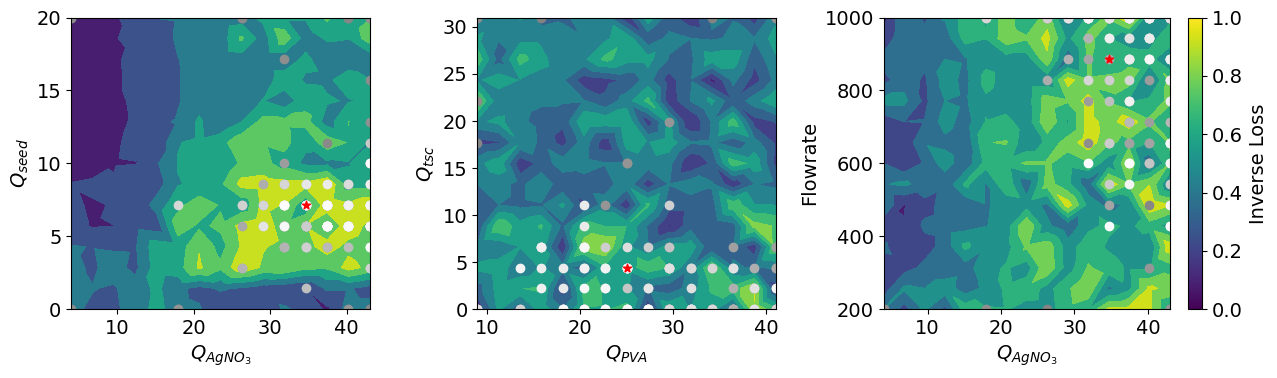

In [79]:
fig = contour_plots(plot_points, y_true, EI_results['bo_points'], best_point)

plt.tight_layout()

plt.savefig('np_EI_contour.png', dpi = 300)

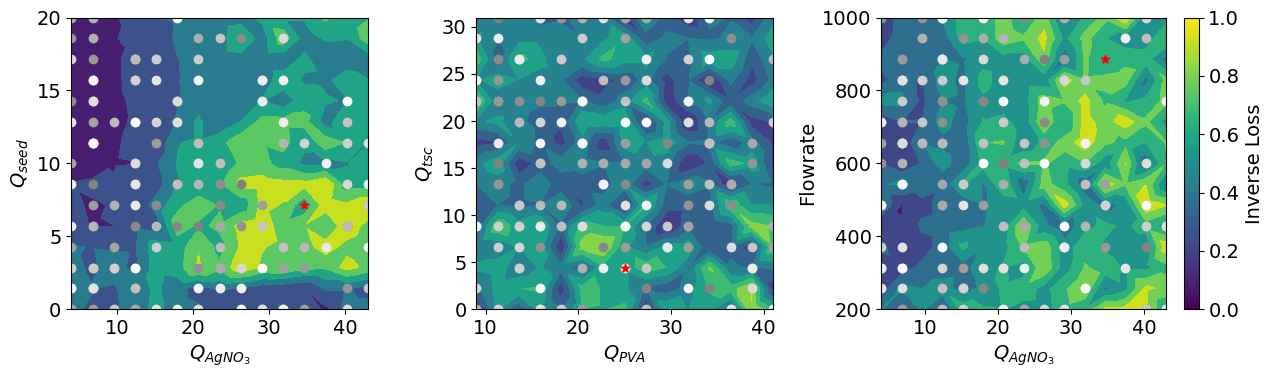

In [80]:
fig = contour_plots(plot_points, y_true, EI_results['rand_points'], best_point)
plt.savefig('np_random_contour.png', dpi = 300)

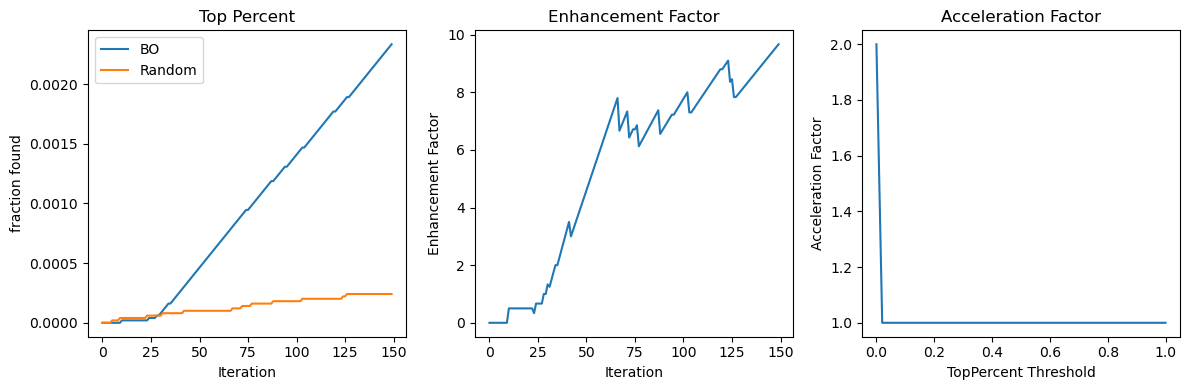

In [35]:
fig = metrics_plot(EI_results)

## b. Upper Confidence Bound

In [36]:
kernel = kernels.Matern(nu = 1/2)
#kernel = kernels.DotProduct()
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 0.01)
acq = acquisitions.optimize_UCB
acq_kwargs = {'beta':1}
n_its = 150
init_data = (selected_points, y_init)
y_true = oracle.predict(all_points)

UCB_results = run_bo_campaign(oracle, internal_model, acq, init_data, all_points, y_true, n_its = n_its, acq_kwargs = acq_kwargs)

/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


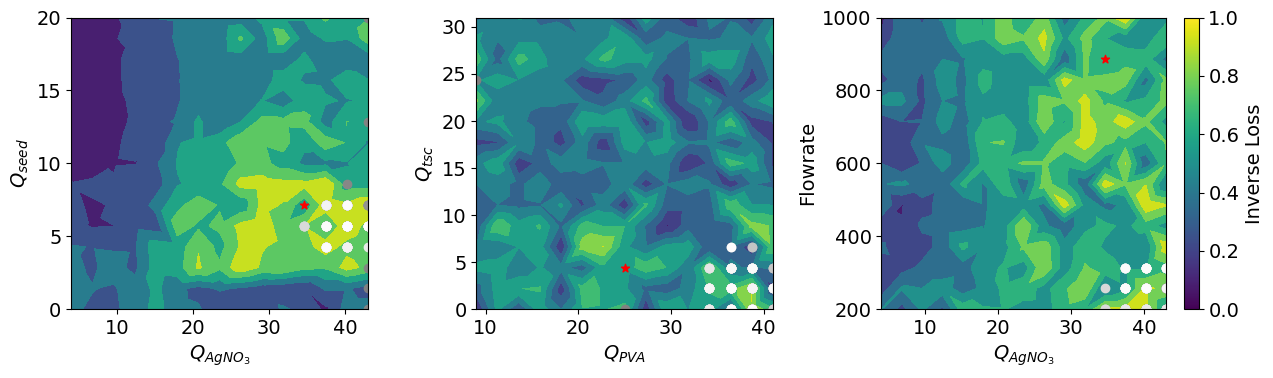

In [81]:
fig = contour_plots(plot_points, y_true, UCB_results['bo_points'], best_point)
plt.savefig('np_UCB_contour.png', dpi = 300)

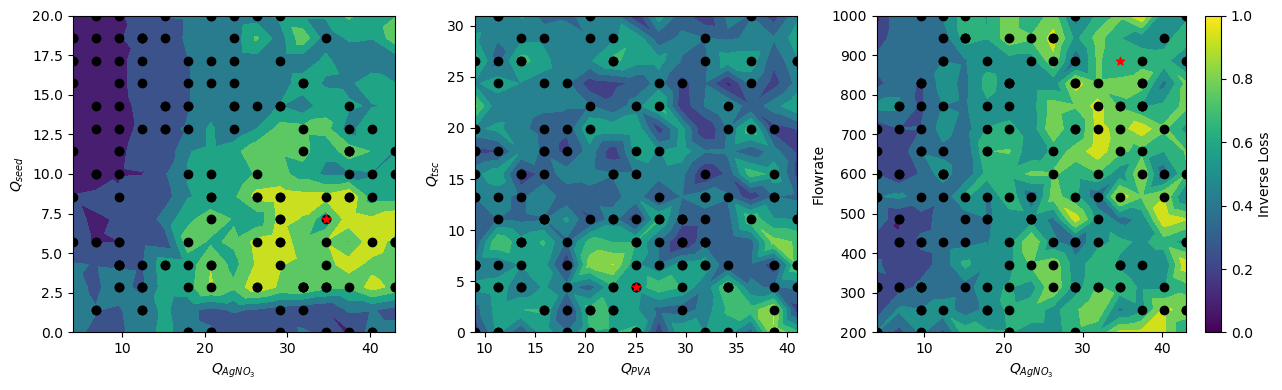

In [38]:
fig = contour_plots(plot_points, y_true, UCB_results['rand_points'], best_point)

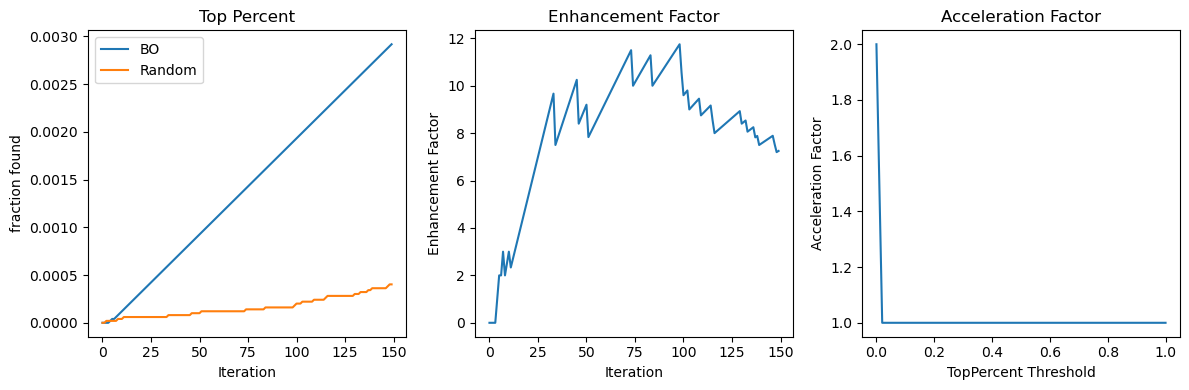

In [39]:
fig = metrics_plot(UCB_results)

### Probability of Improvement

In [40]:
kernel = kernels.Matern(nu = 1/2)
#kernel = kernels.DotProduct()
internal_model = model.GaussianProcessModel(kernel, scale = True, alpha = 0.01)
acq = acquisitions.optimize_PI
acq_kwargs = {'xi':0.25}
n_its = 150
init_data = (selected_points, y_init)
y_true = oracle.predict(all_points)

PI_results = run_bo_campaign(oracle, internal_model, acq, init_data, all_points, y_true, n_its = n_its, acq_kwargs = acq_kwargs)

/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: divide by zero encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)
/Users/bgpelkie/Code/bayesopt/bayesopt/metrics.py:76: RuntimeWarning: invalid value encountered in divide
  ef = np.array(bo_top_percent)/np.array(random_top_percent)


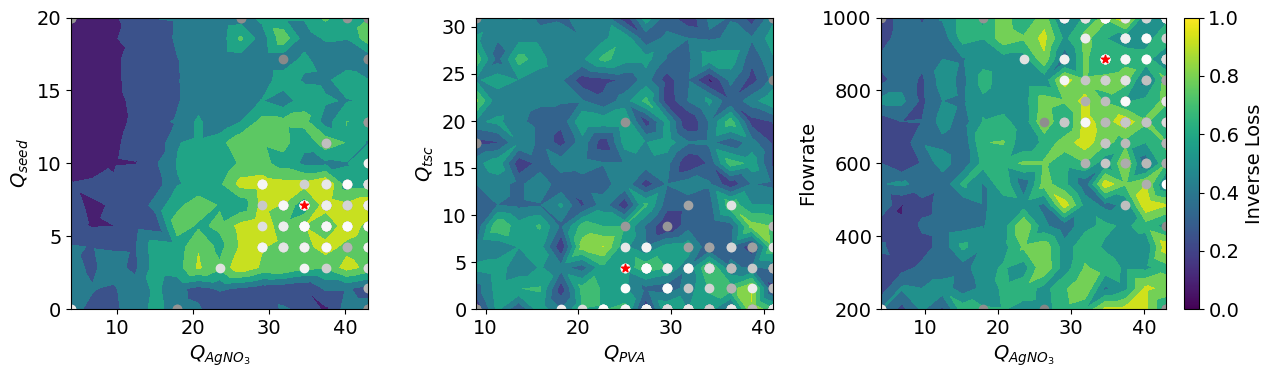

In [82]:
fig = contour_plots(plot_points, y_true, PI_results['bo_points'], best_point)
plt.savefig('np_PI_contour.png', dpi = 300)

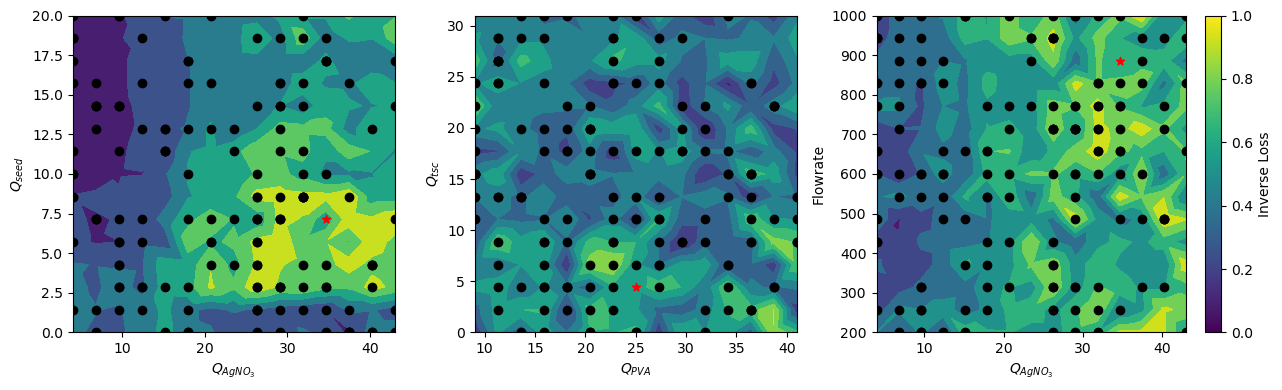

In [42]:
fig = contour_plots(plot_points, y_true, PI_results['rand_points'], best_point)

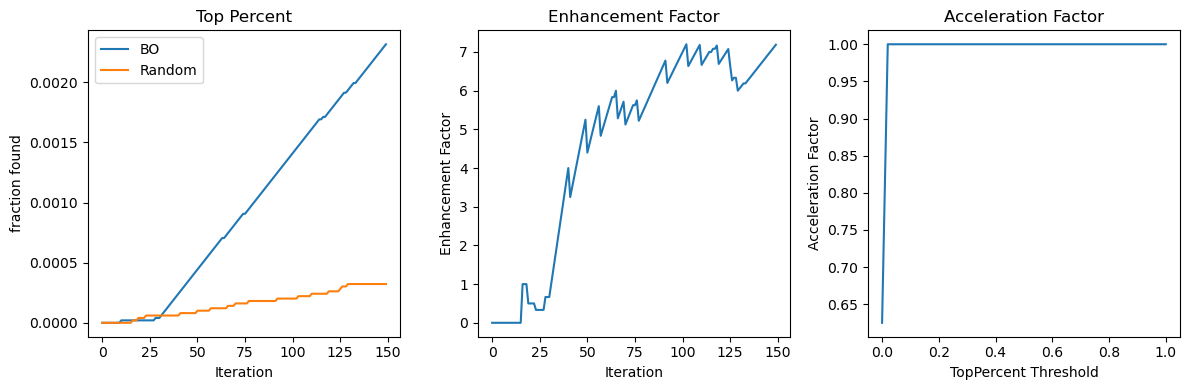

In [43]:
fig = metrics_plot(PI_results)

## Composite plots

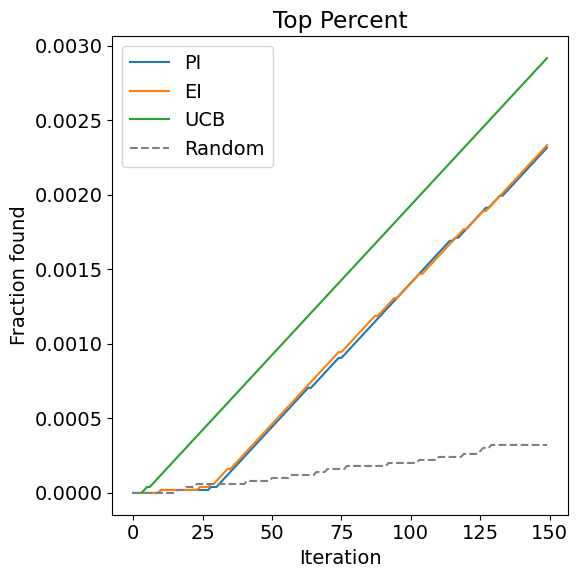

In [86]:
fig, ax = plt.subplots(figsize = (6,6))

ax.plot(PI_results['bo_toppercent'], label = 'PI')
ax.plot(EI_results['bo_toppercent'], label = 'EI')
ax.plot(UCB_results['bo_toppercent'], label = 'UCB')
ax.plot(PI_results['rand_toppercent'], label = 'Random', color = 'gray', ls = '--')

ax.set_xlabel('Iteration')
ax.set_ylabel('Fraction found')
ax.legend()
ax.set_title('Top Percent')
plt.tight_layout()
plt.savefig('np_toppercent_composite.png', dpi = 300)

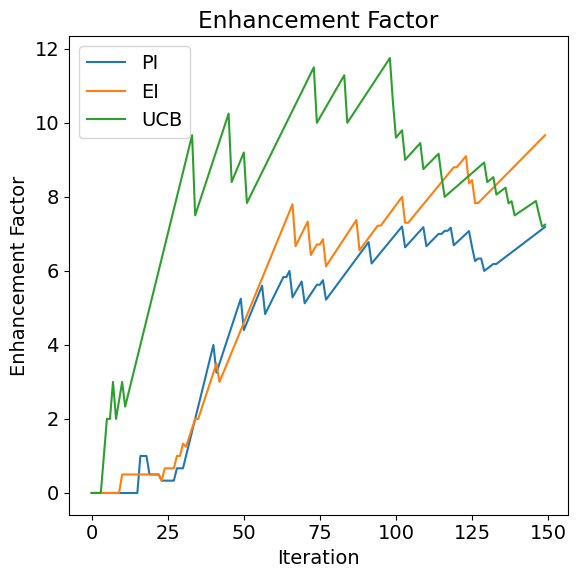

In [87]:
fig, ax = plt.subplots(figsize = (6,6))

ax.plot(PI_results['enhancement_factor'], label = 'PI')
ax.plot(EI_results['enhancement_factor'], label = 'EI')
ax.plot(UCB_results['enhancement_factor'], label = 'UCB')
ax.set_xlabel('Iteration')
ax.set_ylabel('Enhancement Factor')
ax.set_title('Enhancement Factor')
plt.tight_layout()
ax.legend()
plt.savefig('Np_enhance.png', dpi = 300)